## README
Dataset can be found [here](https://zindi.africa/competitions/spot-the-mask/data)

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import transforms
from torchvision.io import read_image, ImageReadMode

import os
import random
import math
from datetime import datetime
from sklearn.metrics import roc_auc_score

In [29]:
## funciton to calculate width and height of convolution layer
def conv_out_dim(shape_in, padding=[0,0], dialation=[1,1], kernel_size=[2,2], stride=[1,1]):
#     dim = 0
    dimensions = []
    for dim in range(2):
        dimension = (shape_in[dim]+2*padding[dim]-dialation[dim]*(kernel_size[dim]-1)-1)/stride[dim] + 1
        dimensions.append(math.floor(dimension))
    return dimensions

In [30]:
class MaskedFaces(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0])
        image = read_image(img_path, mode=ImageReadMode.GRAY)
        ## discarding the alpha channels
        label = self.img_labels.iloc[idx,1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [31]:
## preparing to load the images
annotations_file = "./data/train_labels.csv"
img_dir = "./data/images"
transform = transforms.Compose([transforms.Resize((100,100), antialias=True), transforms.ConvertImageDtype(torch.float32)])
target_transform = lambda x: torch.tensor(x).type(torch.float32)
dataset = MaskedFaces(annotations_file, img_dir, transform=transform, target_transform=target_transform)

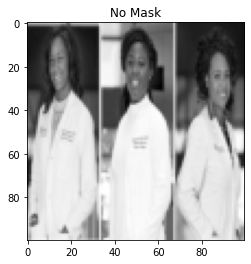

In [32]:
idx = np.random.randint(len(dataset)+1)
img = dataset[idx][0]
label = dataset[idx][1]
plt.imshow(img.permute(1,2,0), cmap="gray")
plt.title("Has Mask" if label else "No Mask")
plt.show()

In [33]:
# splitting data into train and test
generator = torch.Generator().manual_seed(42)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.7,0.3], generator=generator)

In [34]:
## creating model
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()

        ## creating convolutional layers
        self.conv = nn.Sequential(nn.Conv2d(1, 16, kernel_size=3, stride=2),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(16),
                                  nn.Conv2d(16, 32, kernel_size=3, stride=2),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(32),
                                  nn.Conv2d(32, 64, kernel_size=3, stride=2),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(64),
                                  nn.Conv2d(64, 128, kernel_size=3, stride=2),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(128)
                                 )

        self.dense = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(5*5*128, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, K),
            nn.Sigmoid()
            )

    def forward(self, X):
        X = self.conv(X)
        X = X.view(X.shape[0], -1)
        X = self.dense(X)
        return X

In [35]:
## preparting tools for training
model = CNN(1)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

In [36]:
## determining size of data after convolution
dim = conv_out_dim((100,100), padding=[0,0], dialation=[1,1], kernel_size=[3,3], stride=[2,2])
dim = conv_out_dim(dim,kernel_size=[3,3], stride=[2,2])
dim = conv_out_dim(dim,kernel_size=[3,3], stride=[2,2])
dim = conv_out_dim(dim,kernel_size=[3,3], stride=[2,2])
dim

[5, 5]

In [37]:
## creating dataloaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True
                                          )

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                           shuffle=False
                                          )

In [38]:
## creating training function
def train_model(model, criterion, optimizer, train_loader, test_loader, epochs):
    info = {"train_losses": [], "test_losses":[]}
    for it in range(epochs):
        time_start = datetime.now()
        ## training
        model.train()
        epoch_losses = []
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.view(-1,1))
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

        ## adding mean of loss to train losses
        info["train_losses"].append(np.mean(epoch_losses))

        ## resetting epoch losses
        epoch_losses = []

        ## testing
        model.eval()
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets.view(-1,1))
            epoch_losses.append(loss.item())

        ## adding mean of loss to test losses
        info["test_losses"].append(np.mean(epoch_losses))

        ## getting duration of epochs
        dt = datetime.now() - time_start
        ## printing after epoch
        print(f"Train Loss {info['train_losses'][-1]}, Test Loss {info['test_losses'][-1]}, Duration {dt}")
                                   
    return info

In [39]:
## training model
train_info = train_model(model, criterion, optimizer, train_loader, test_loader, 10)

Train Loss 0.7224737008412679, Test Loss 0.7018665501049587, Duration 0:00:12.455000
Train Loss 0.378947122891744, Test Loss 0.7603059751646859, Duration 0:00:11.387002
Train Loss 0.23159483273824055, Test Loss 0.7740310856274196, Duration 0:00:11.016041
Train Loss 0.12735474010308584, Test Loss 0.9433806453432355, Duration 0:00:10.403010
Train Loss 0.06522564515471459, Test Loss 1.0752219472612654, Duration 0:00:10.856009
Train Loss 0.03932288450499376, Test Loss 1.2016687137739999, Duration 0:00:10.449010
Train Loss 0.027234678777555626, Test Loss 1.4052868230002267, Duration 0:00:10.805004
Train Loss 0.029473403779168923, Test Loss 1.4552567516054427, Duration 0:00:10.601000
Train Loss 0.02954716222981612, Test Loss 1.6858156834329878, Duration 0:00:10.528003
Train Loss 0.04868028339308997, Test Loss 1.6236814260482788, Duration 0:00:10.716009


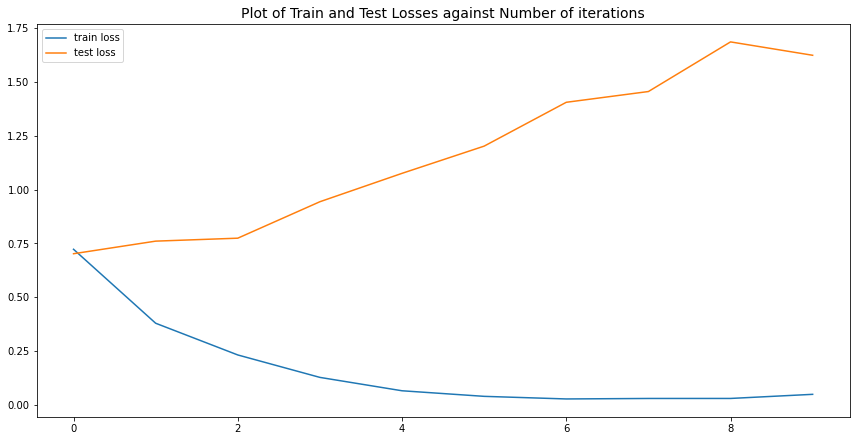

In [40]:
fig = plt.figure(figsize=(12,6))
plt.plot(train_info["train_losses"], label="train loss")
plt.plot(train_info["test_losses"], label="test loss")
plt.tight_layout()
plt.title("Plot of Train and Test Losses against Number of iterations", fontdict={"size":14})
plt.legend()
plt.show()

In [51]:
## getting accuracies
test_acc = 0
train_acc = 0

with torch.no_grad():
    model.eval()
    
    num_correct = 0
    total = 0
    for inputs, targets in train_loader:
        preds = model(inputs)
        num_correct += (np.round(preds.numpy().flatten()) == targets.numpy().flatten()).sum()
        total += len(targets)
    
    train_acc = num_correct/total
    
    num_correct = 0
    total = 0
    for inputs, targets in test_loader:
        preds = model(inputs)
        num_correct += (np.round(preds.numpy().flatten()) == targets.numpy().flatten()).sum()
        total += len(targets)
    
    test_acc = num_correct/total
    
print(f"Train accuracy: {train_acc}, Test Accuracy: {test_acc}")

Train accuracy: 1.0, Test Accuracy: 0.5841836734693877


In [52]:
## getting AUC score of test data
def get_auc_score(model, dataloader):
    model.eval()
    preds = np.array([])
    pred_targets = np.array([])
    for inputs, targets in dataloader:
        preds = np.concatenate([preds, model(inputs).detach().numpy().flatten()])
        pred_targets = np.concatenate([pred_targets, targets])

    return roc_auc_score(pred_targets, preds)

In [53]:
print(f"AUC Score: {get_auc_score(model, test_loader)}")

AUC Score: 0.6075989032510772


In [20]:
## getting the prediction dataset
annotations_file = "./data/SampleSubmission.csv"
prediction_dataset = MaskedFaces(annotations_file, img_dir, transform=transform, target_transform=target_transform)

In [21]:
pred_data_loader = torch.utils.data.DataLoader(prediction_dataset,
                                               batch_size=len(prediction_dataset),
                                               shuffle=False
                                              )

X_preds, _ = next(iter(pred_data_loader))

model.eval()
preds = model(X_preds)

In [22]:
preds = preds.detach().numpy()

In [23]:
## saving predictions
img_labels = pd.read_csv("data/SampleSubmission.csv").iloc[:,0]
# pd.DataFrame({"image":img_labels.values, "target":preds.flatten()}).to_csv("submission/submission5.csv", index=False)